# Logistic Regression Implementation
This model will focus on predicting whether the defendant was **released or not**.
* 0 -> detained
* 1 -> released 

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
warnings.filterwarnings('always')  

## Data Visualization
### Correlation Matrix
The correlation coefficient has values between -1 to 1
* A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
* A value closer to 1 implies stronger positive correlation
* A value closer to -1 implies stronger negative correlation

In [2]:
def correlation_matrix(data):
    print('Correlation Matrix')
    #Correlation Matrix
    corr = data.corr()
    plt.figure(figsize=(15, 12))
    #plot heat map
    g = sns.heatmap(corr, annot=True, cmap="cool", vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix')
    plt.show()

Correlation Matrix


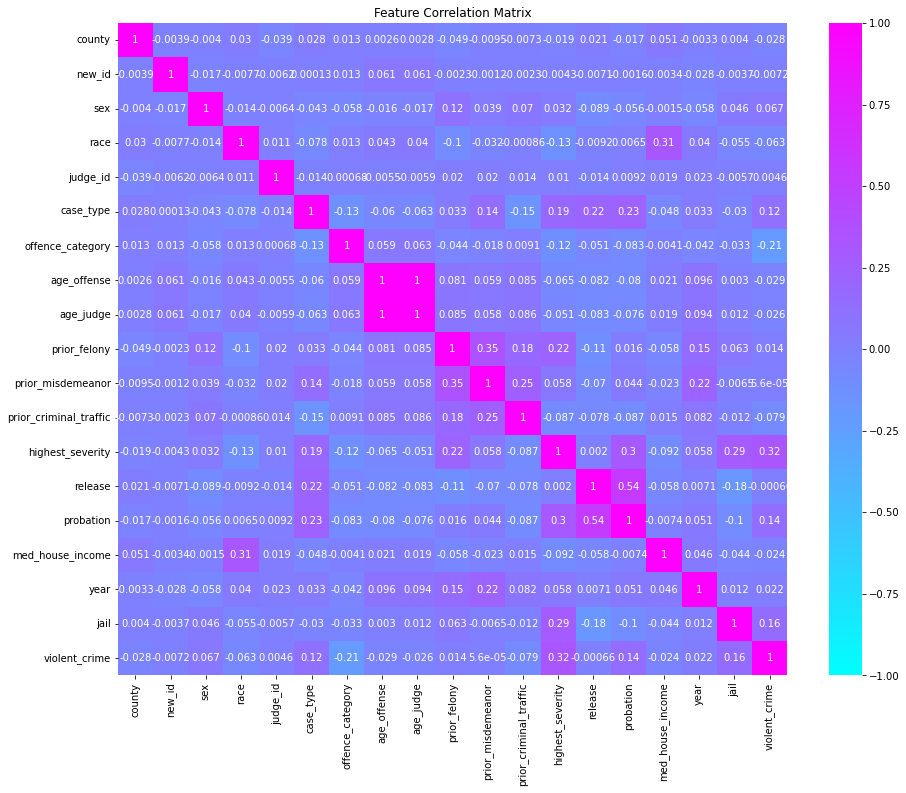

In [3]:
#load data
data = pd.read_csv('sampled_file_100k.csv')

correlation_matrix(data)

### Feature Importance

In [2]:
def load_and_split_data(file, base):
    
    #as per the group discussion the final amount of data used is 100k
    data = pd.read_csv(file) 
    
    #split dataset in features and target variable
    
    #if the model is base then the features were selected by human intervention, 
    #otherwise drop release column only since it is the target variable
    if base == True:
        #print('Model is base')
        x = data.drop(columns = ['new_id', 'release', 'probation', 'med_house_income', 'year'], axis = 1) #features
    else:
        #print('Model is not base')
        x = data.drop(columns = ['release'], axis = 1) #features
    
    y = data['release'].values #target variable

    #split the dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    
    return x, x_train, x_test, y_train, y_test

In [5]:
def feature_importance(model, x_train, y_train):
    
    lr_model = LogisticRegression(max_iter = 1000, random_state = 0)
    lr_model.fit(x_train, y_train)

    feature_importance = abs(lr_model.coef_[0])
    feature_importance = (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    print("Feature Importance")
    featfig = plt.figure(figsize=(12, 6))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(data.columns)[sorted_idx], fontsize=14)

    plt.tight_layout()   
    plt.show()

#### Feature Importance all features

Feature Importance


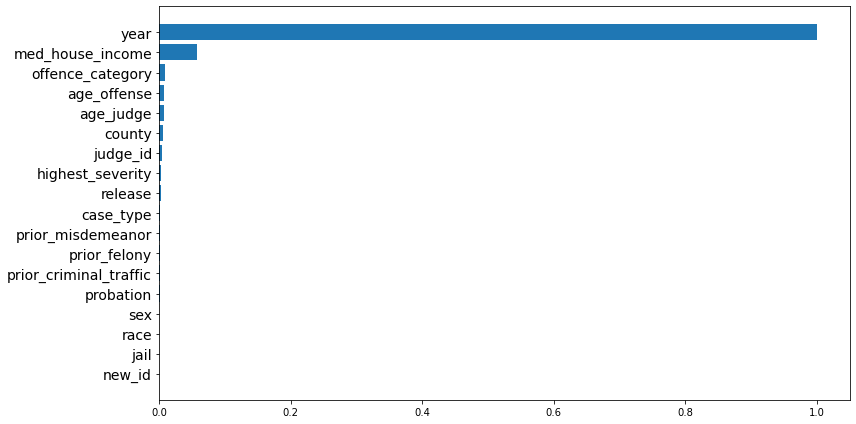

In [6]:
x, x_train, x_test, y_train, y_test = load_and_split_data('sampled_file_100k.csv', False)
lr_model = LogisticRegression(max_iter = 10000)

feature_importance(lr_model, x_train, y_train)

#### Feature Importance on Selected Features

Feature Importance


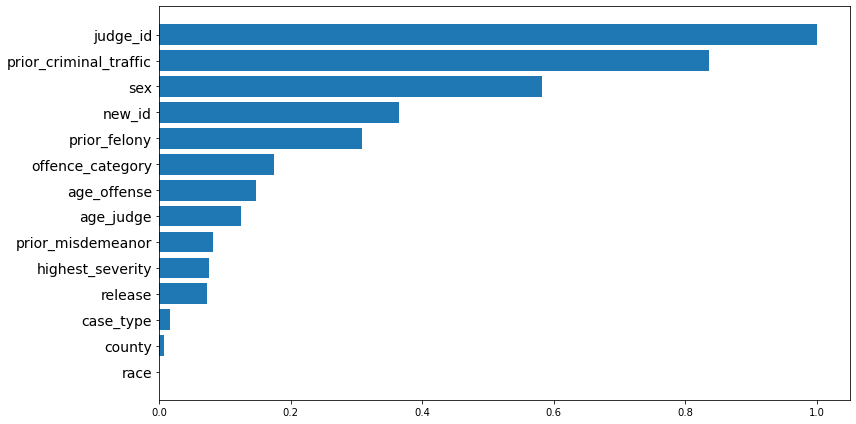

In [7]:
x, x_train, x_test, y_train, y_test = load_and_split_data('sampled_file_100k.csv', True)
lr_model = LogisticRegression(max_iter = 10000)

feature_importance(lr_model, x_train, y_train)

## Model Development

In [3]:
def plot_roc_and_pr_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    ax[0].legend(loc="lower right")
    #ax[0].show()
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ax[1].step(recall, precision, where='post', color='b', alpha=0.7)
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    
    fig.suptitle('\nROC Curve & Precision-Recall Curve', fontsize = 15)
    plt.tight_layout() 
    plt.show()

In [4]:
def evaluate(y_test, y_pred, model, xtrain, ytrain):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    cross_val = cross_val_score(model, xtrain, ytrain, scoring='accuracy', cv=5)
    std_dev = cross_val.std()
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print("\n--------------- Evaluation ---------------")
    print(f'Accuracy: {accuracy:.3}')
    print(f'Precision: {precision:.3}')
    print(f'Recall: {recall:.3}')
    print(f'F1 Score: {f1score:.3}')
    print(f'ROC AUC: {auc:.3}')
    print(f'Standard Deviaiton (Accuracy): {std_dev:.3}')
    #print(f'\nConfusion Matrix: \n {conf_matrix}')
    print(f'\nClassification Report: ')
    print(classification_report(y_test, y_pred, target_names=['0 - Detained', '1 - Released']))
    #print(f'\nConfusion Matrix: \n {conf_matrix}')
    print("\n--------------- Visual Evaluation ---------------")
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'cool')
    #disp.plot()
    fig = disp.figure_
    fig.set_figwidth(14)
    fig.set_figheight(5) 
    fig.suptitle('Confusion Matrix', fontsize = 15)
    plt.show()
    
    plot_roc_and_pr_curve(y_test, y_pred)

### Base Model

--------------- BASE MODEL (Defualt Params) ---------------

--------------- Features Selected ---------------
county
new_id
sex
race
judge_id
case_type
offence_category
age_offense
age_judge
prior_felony
prior_misdemeanor
prior_criminal_traffic
highest_severity
probation
med_house_income
year
jail
violent_crime

--------------- Evaluation ---------------
Accuracy: 0.779
Precision: 0.762
Recall: 0.961
F1 Score: 0.85
ROC AUC: 0.699
Standard Deviaiton (Accuracy): 0.00256

Classification Report: 
              precision    recall  f1-score   support

0 - Detained       0.86      0.44      0.58      6965
1 - Released       0.76      0.96      0.85     13035

    accuracy                           0.78     20000
   macro avg       0.81      0.70      0.71     20000
weighted avg       0.80      0.78      0.76     20000


--------------- Visual Evaluation ---------------


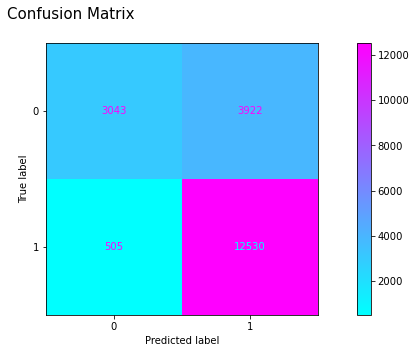

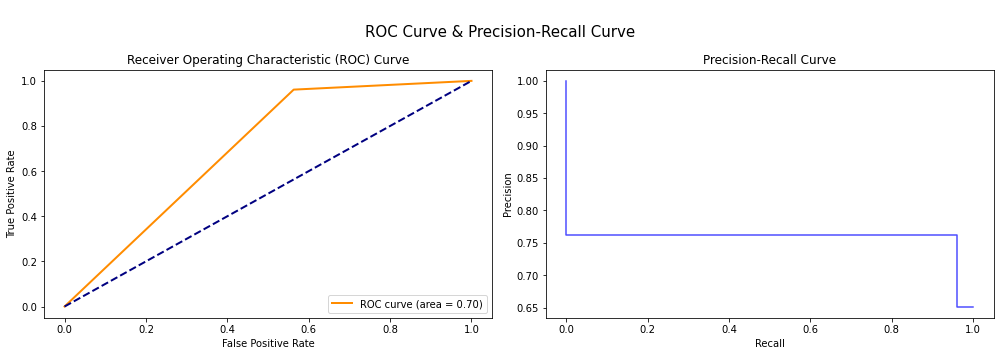


Process finished in 4.13 seconds


['lr_base_model2.joblib']

In [5]:
#Base model with all features
print("--------------- BASE MODEL (Defualt Params) ---------------\n")
start_time = time.time()
x, x_train, x_test, y_train, y_test = load_and_split_data('sampled_file_100k.csv', False)

print("--------------- Features Selected ---------------")
for i in x_train.columns.values:
    print(i)

lr_model = LogisticRegression(max_iter = 10000)

lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)

evaluate(y_test, y_pred, lr_model, x_train, y_train)

print(f'\nProcess finished in {time.time() - start_time:.2f} seconds')

#export model
joblib.dump(lr_model, 'lr_base_model2.joblib')

--------------- BASE MODEL (Defualt Params) ---------------

--------------- Features Selected ---------------
county
sex
race
judge_id
case_type
offence_category
age_offense
age_judge
prior_felony
prior_misdemeanor
prior_criminal_traffic
highest_severity
jail
violent_crime

--------------- Evaluation ---------------
Accuracy: 0.803
Precision: 0.788
Recall: 0.954
F1 Score: 0.863
ROC AUC: 0.737
Standard Deviaiton (Accuracy): 0.00142

Classification Report: 
              precision    recall  f1-score   support

0 - Detained       0.86      0.52      0.65      6965
1 - Released       0.79      0.95      0.86     13035

    accuracy                           0.80     20000
   macro avg       0.82      0.74      0.76     20000
weighted avg       0.81      0.80      0.79     20000


--------------- Visual Evaluation ---------------


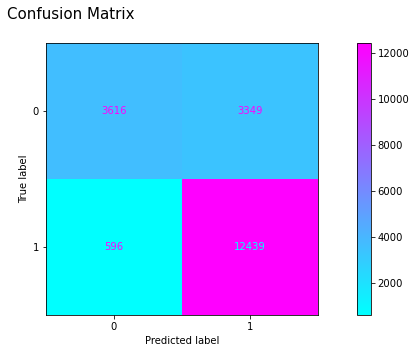

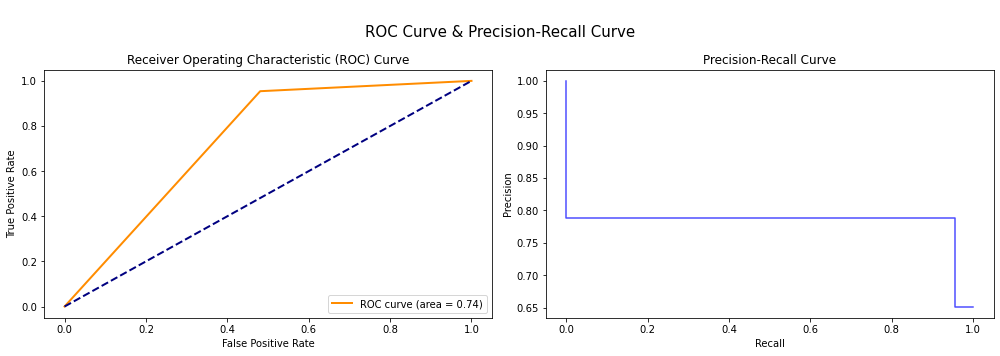


Process finished in 18.59 seconds


['lr_base_model.joblib']

In [10]:
#base model with human selected features
print("--------------- BASE MODEL (Defualt Params) ---------------\n")
start_time = time.time()
x, x_train, x_test, y_train, y_test = load_and_split_data('sampled_file_100k.csv', True)

print("--------------- Features Selected ---------------")
for i in x_train.columns.values:
    print(i)

lr_model = LogisticRegression(max_iter = 10000)

lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)

evaluate(y_test, y_pred, lr_model, x_train, y_train)

print(f'\nProcess finished in {time.time() - start_time:.2f} seconds')

#export model
joblib.dump(lr_model, 'lr_base_model.joblib')

In [11]:
def apply_pca(x_train, x_test, x):
    print("--------------- Applying PCA ---------------")

    pca = PCA() 
    #Hyperparameter Tuning 
    #Random state - no effect
    #n_components - numbers made little different. When flaots the model does badly >0.5

    X_train_pca = pca.fit_transform(x_train)
    X_test_pca = pca.transform(x_test)
    
# #used to get the list of the most important components (not top 3)
#     # number of components
#     n_pcs= pca.components_.shape[0]

#     # get the index of the most important feature on EACH component
#     most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

#     initial_feature_names = x_train.columns.values
#     # get the names
#     most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
#     print(f"Number of Principal Components: {pca.n_components_}") #same as most important
#     print(f"Selected Features: {most_important_names}")

    #get number of components
    components = pca.components_
    
    # Identifying top contributing features for each principal component
    top_features_per_component = {}
    for i, component in enumerate(components):
        # Getting indices of top contributing features for this component
        top_feature_indices = np.argsort(-np.abs(component))[:3]
        # Mapping indices to feature names
        top_features = [x[idx] for idx in top_feature_indices]
        top_features_per_component[i] = top_features
        
    print(f"Number of Principal Components: {pca.n_components_}")
    for component, features in top_features_per_component.items():
        print(f"Component {component}: {features}")
    
    return X_train_pca, X_test_pca


## PCA Based Model

--------------- LR PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 18
Component 0: ['new_id', 'med_house_income', 'jail']
Component 1: ['med_house_income', 'jail', 'judge_id']
Component 2: ['jail', 'judge_id', 'med_house_income']
Component 3: ['judge_id', 'jail', 'county']
Component 4: ['county', 'offence_category', 'prior_felony']
Component 5: ['offence_category', 'age_judge', 'age_offense']
Component 6: ['age_judge', 'age_offense', 'offence_category']
Component 7: ['year', 'prior_misdemeanor', 'prior_felony']
Component 8: ['highest_severity', 'prior_felony', 'prior_misdemeanor']
Component 9: ['prior_misdemeanor', 'prior_felony', 'highest_severity']
Component 10: ['prior_felony', 'prior_misdemeanor', 'prior_criminal_traffic']
Component 11: ['prior_criminal_traffic', 'prior_felony', 'highest_severity']
Component 12: ['race', 'prior_felony', 'case_type']
Component 13: ['case_type', 'age_offense', 'age_judge']
Component 14: ['age_of

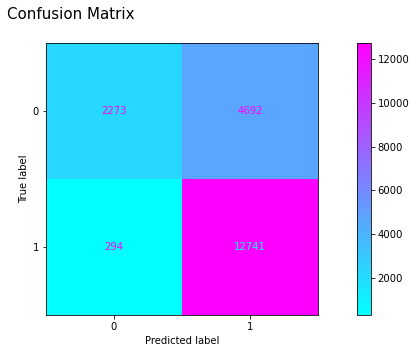

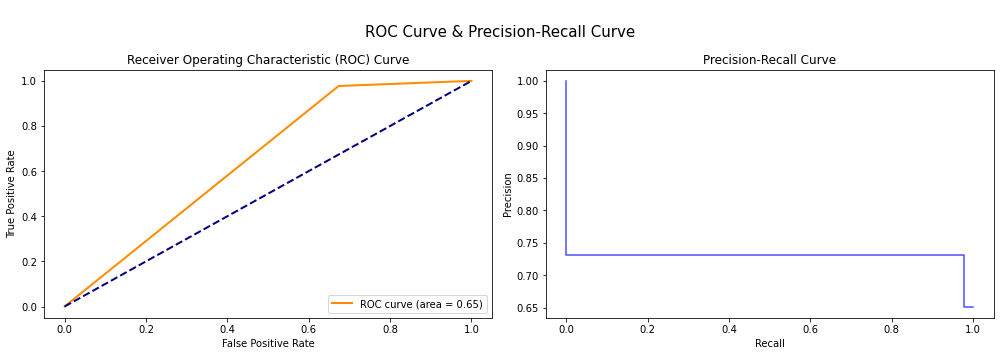


Process finished in 4.57 seconds


['lr_pca_model.joblib']

In [12]:
print("--------------- LR PCA MODEL ---------------\n")
start_time = time.time()
x, x_train, x_test, y_train, y_test = load_and_split_data('sampled_file_100k.csv', False)

X_train_pca, X_test_pca = apply_pca(x_train, x_test, x.columns)

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_lr_model = LogisticRegression(max_iter = 1000)
#random state - no effect

# Train the model
pca_lr_model.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = pca_lr_model.predict(X_test_pca)

evaluate(y_test, y_pred, lr_model, x_train, y_train)
print(f'\nProcess finished in {time.time() - start_time:.2f} seconds')

#export model
joblib.dump(lr_model, 'lr_pca_model.joblib')

In [13]:
def apply_ffs(model, x_train, x_test, y_train, x):
    print("--------------- Applying FFS ---------------")
    #Apply FFS
    # Apply forward feature selection on the PCA-transformed data
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward')
    X_train_selected = sfs.fit_transform(x_train, y_train)
    X_test_selected = sfs.transform(x_test)

    print("\nNumber of Features selected by Forward Feature Selection:", X_train_selected.shape[1], "\n")

    # Get the indices of selected features
    selected_feature_indices = sfs.get_support(indices=True)

    # Get the names of selected features
    selected_feature_names = [x[i] for i in selected_feature_indices]
    #new_features = X_train_pca[selected_feature_indices]

    print("Features selected by Forward Feature Selection:")
    print(F"Features selected by Forward Feature Selection: {selected_feature_names}")
    
    return X_train_selected, X_test_selected 


## FFS Based Model

--------------- LR FFS MODEL ---------------

--------------- Applying FFS ---------------

Number of Features selected by Forward Feature Selection: 9 

Features selected by Forward Feature Selection:
Features selected by Forward Feature Selection: ['race', 'case_type', 'offence_category', 'prior_felony', 'highest_severity', 'probation', 'year', 'jail', 'violent_crime']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.832
Precision: 0.828
Recall: 0.936
F1 Score: 0.879
ROC AUC: 0.787
Standard Deviaiton (Accuracy): 0.0025

Classification Report: 
              precision    recall  f1-score   support

0 - Detained       0.84      0.64      0.73      6965
1 - Released       0.83      0.94      0.88     13035

    accuracy                           0.83     20000
   macro avg       0.84      0.79      0.80     20000
weighted avg       0.83      0.83      0.83     20000


--------------- Visual Evaluation ---------------


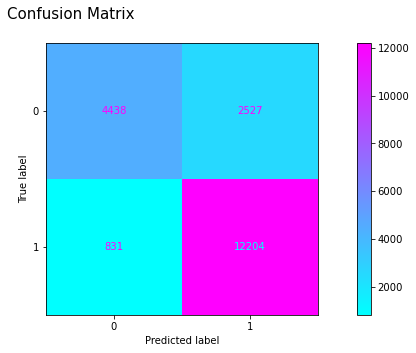

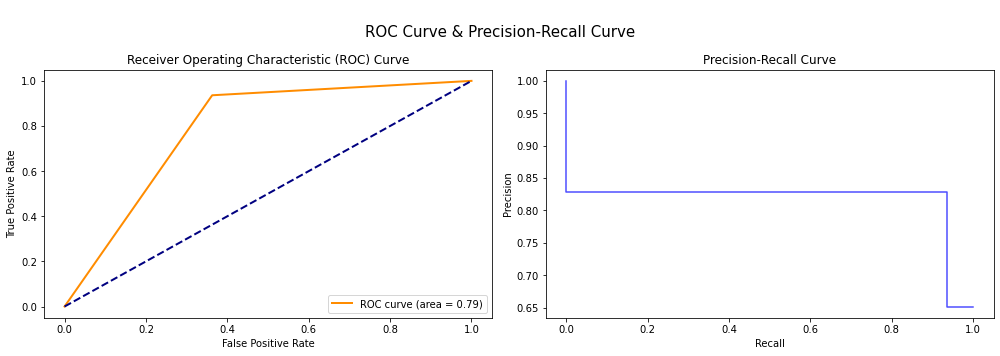


Process finished in 126.43 seconds


['lr_ffs_model.joblib']

In [14]:
print("--------------- LR FFS MODEL ---------------\n")
start_time = time.time()
x, x_train, x_test, y_train, y_test = load_and_split_data('sampled_file_100k.csv', False)

lr_model = LogisticRegression(max_iter = 1000)


X_train_ffs, X_test_ffs = apply_ffs(lr_model, x_train, x_test, y_train, x.columns)

print("--------------- Model Training ---------------")
# Train the model
lr_model.fit(X_train_ffs, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test_ffs)

evaluate(y_test, y_pred, lr_model, X_train_ffs, y_train)
print(f'\nProcess finished in {time.time() - start_time:.2f} seconds')

#export model
joblib.dump(lr_model, 'lr_ffs_model.joblib')

## Model using PCA & FFS

--------------- LR PCA & FFS MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 18
Component 0: ['new_id', 'med_house_income', 'age_judge']
Component 1: ['med_house_income', 'jail', 'judge_id']
Component 2: ['jail', 'med_house_income', 'judge_id']
Component 3: ['judge_id', 'jail', 'county']
Component 4: ['county', 'offence_category', 'prior_felony']
Component 5: ['offence_category', 'age_judge', 'age_offense']
Component 6: ['age_judge', 'age_offense', 'offence_category']
Component 7: ['year', 'prior_misdemeanor', 'prior_felony']
Component 8: ['highest_severity', 'prior_felony', 'prior_misdemeanor']
Component 9: ['prior_misdemeanor', 'prior_felony', 'highest_severity']
Component 10: ['prior_felony', 'prior_misdemeanor', 'prior_criminal_traffic']
Component 11: ['prior_criminal_traffic', 'prior_felony', 'highest_severity']
Component 12: ['race', 'prior_felony', 'case_type']
Component 13: ['case_type', 'age_offense', 'age_judge']
Component 1

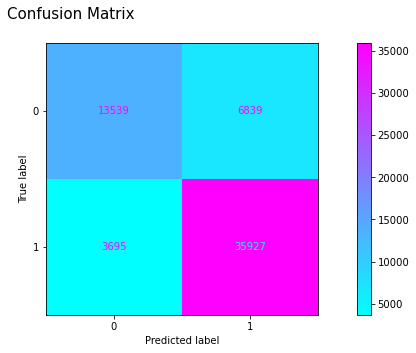

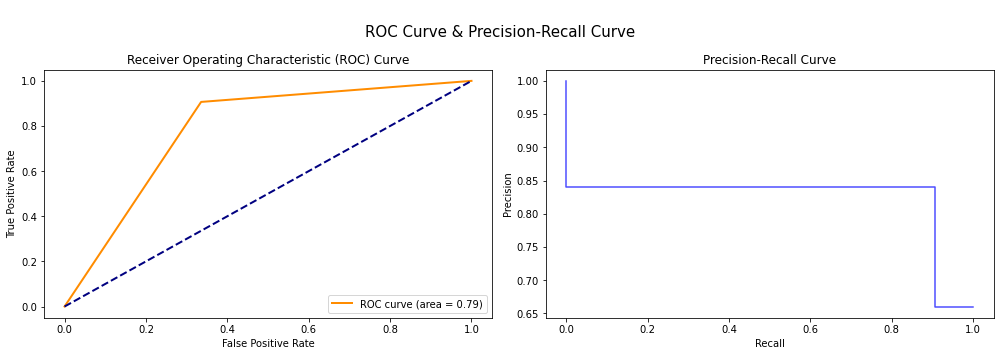


Process finished in 601.30 seconds


['lr_pca_fss_model.joblib']

In [15]:
print("--------------- LR PCA & FFS MODEL ---------------\n")
start_time = time.time()

#load and split the data
x, x_train, x_test, y_train, y_test = load_and_split_data('Data/sampled_file_300k.csv', False)

#apply PCA
x_train_pca, x_test_pca = apply_pca(x_train, x_test, x.columns)

#create the classifier (needed for FFS)
lr_model = LogisticRegression(max_iter = 1000)

#apply FFS
x_train_ffs, x_test_ffs = apply_ffs(lr_model, x_train_pca, x_test_pca, y_train, x.columns)

print("--------------- Model Hyperparameters ---------------")
print(lr_model.get_params())

print("--------------- Model Training ---------------")
# Train the model
lr_model.fit(x_train_ffs, y_train)

# Predict on the test data
y_pred = lr_model.predict(x_test_ffs)

evaluate(y_test, y_pred, lr_model, x_train_ffs, y_train)

print(f'\nProcess finished in {time.time() - start_time:.2f} seconds')

#export model
joblib.dump(lr_model, 'lr_pca_fss_model.joblib')

## Model using PCA & FFS with GridSearchCV 

GridSearchCV was taking extremely too long for this ML technique. That is why the GridSearch was conducted individually using much less data. The best parameters were noted and used to train the following the model. 

--------------- LR PCA & FFS MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 18
Component 0: ['new_id', 'med_house_income', 'jail']
Component 1: ['med_house_income', 'jail', 'judge_id']
Component 2: ['jail', 'judge_id', 'med_house_income']
Component 3: ['judge_id', 'jail', 'county']
Component 4: ['county', 'offence_category', 'prior_felony']
Component 5: ['offence_category', 'age_judge', 'age_offense']
Component 6: ['age_judge', 'age_offense', 'offence_category']
Component 7: ['year', 'prior_misdemeanor', 'prior_felony']
Component 8: ['highest_severity', 'prior_felony', 'prior_misdemeanor']
Component 9: ['prior_misdemeanor', 'prior_felony', 'highest_severity']
Component 10: ['prior_felony', 'prior_misdemeanor', 'prior_criminal_traffic']
Component 11: ['prior_criminal_traffic', 'prior_felony', 'highest_severity']
Component 12: ['race', 'prior_felony', 'case_type']
Component 13: ['case_type', 'age_offense', 'age_judge']
Component 14: ['

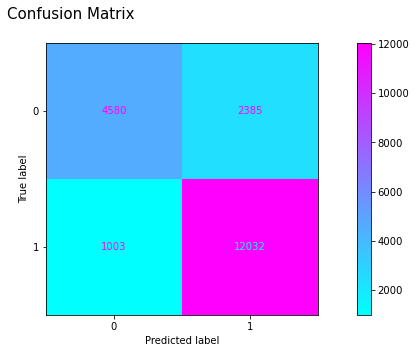

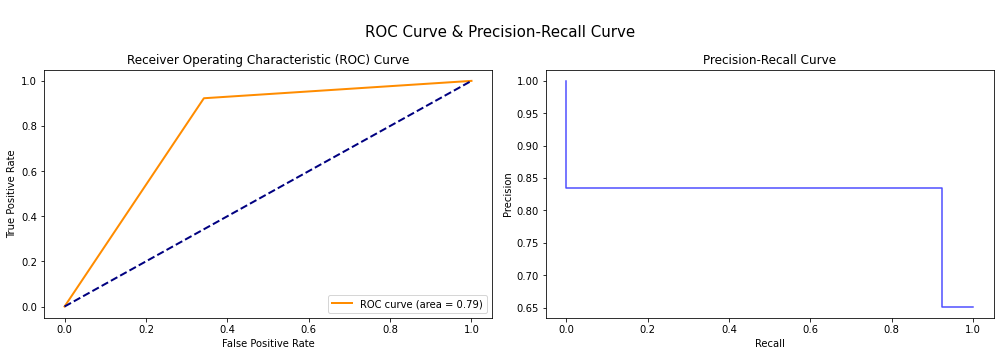


Process finished in 710.17 seconds


['lr_lbfgs_model.joblib']

In [16]:
print("--------------- LR PCA & FFS MODEL ---------------\n")
start_time = time.time()

#load and split the data
x, x_train, x_test, y_train, y_test = load_and_split_data('sampled_file_100k.csv', False)

#apply PCA
x_train_pca, x_test_pca = apply_pca(x_train, x_test, x.columns)

#create the classifier using GridSearchCV best params from testing with 20
lr_model = LogisticRegression(C = 1.0, 
                              max_iter = 10000, 
                              n_jobs = -1, 
                              penalty = 'l2', 
                              random_state = 0, 
                              solver = 'lbfgs')

#apply FFS
x_train_ffs, x_test_ffs = apply_ffs(lr_model, x_train_pca, x_test_pca, y_train, x.columns)

print("--------------- Model Hyperparameters ---------------")
print(lr_model.get_params())

print("--------------- Model Training ---------------")
# Train the model
lr_model.fit(x_train_ffs, y_train)

# Predict on the test data
y_pred = lr_model.predict(x_test_ffs)

evaluate(y_test, y_pred, lr_model, x_train_ffs, y_train)

print(f'\nProcess finished in {time.time() - start_time:.2f} seconds')

#export model
joblib.dump(lr_model, 'lr_lbfgs_model.joblib')